## Supervised machine learning

Having explored some unsupervised machine learning methods earlier, we will move on to supervised techniques. Supervised learning is the task of finding a mapping from input data to output labels based on example input-output pairs. During the training (or fitting) phase, the model builds an internal function which maps input to output, ideally in a way that can be generalized to yet-unseen data successfully. Once a model is trained, it can be used to predict output labels from new input data alone.

They come in two main groups: classifiers for categorical labels, and regressors for continuous numeric labels.

Our first dataset, like yesterday, will be the mice gene expression data on the input side, and the categorical diet labels on the output (also referred to as "target") side. The first supervised model that we will train and evaluate will be a support vector classifier.

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

We will load the expression and diet label data the same way as we did yesterday, and again, we will transpose the table so that samples correspond to rows, and the so-called "features" correspond to columns. From now on, instead of `True/False` we will use `1/0` when encoding the diet target labels, for compatibility with a larger range of models.

In [2]:
#xls = pd.read_excel('../data-livermito/aad0189_DataFileS5.xlsx', header=2)
xls = pd.read_excel('Day2_Files\\aad0189_DataFileS5.xlsx', header = 2)
expr = xls.groupby('Gene.1').mean()
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification

data = expr.T    # use the name 'data' for input
target = 1 * is_hfd  # use the name 'target' for the labels / expected outputs. Let's convert it to 1's and 0's.

## Task 1: Create a support vector classifier (SVC) using a linear kernel

### 1.1: Train it with the whole dataset
Use a simple linear kernel for the SVC.

In [19]:
clf = SVC(kernel = 'linear')
clf.fit(data, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### 1.2: Evaluate its accuracy on the training data
We are asking you to commit a **mortal sin**: evaluate a machine learning algorithm on the same data that you had trained it with. But do it anyway. Are you surprised by its accuracy?

In [20]:
res1 = clf.predict(data)
pd.crosstab(res1, is_hfd)

col_0,False,True
row_0,,
0,41,0
1,0,40


### 1.3: Compare the support vector with the 4 direction vectors from yesterday's PCA
To save you the trouble of moving code between sheets, we provided you the PCA code below, and put the principal direction vectors in a DataFrame. Add the linear support vector, find a suitable way of comparing it with the principal direction vectors, and discuss what you found.

In [10]:
pca = PCA(n_components=4)
pca.fit(data)
coeffs = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2', 'pc3', 'pc4'])
# coeffs['linear_svc'] = ...

In [33]:
sup_vec1 = clf.support_vectors_.T
norm_vec_hyper = clf.coef_
print(np.shape(norm_vec_hyper))
print(np.shape(coeffs))
norm_vec_hyper
coeffs['linear_svc'] = norm_vec_hyper.T
coeffs
#coeffs
#coeffs[]
for en in ['pc1', 'pc2', 'pc3', 'pc4']:
    corrcoeff = np.corrcoef(coeffs[en], coeffs['linear_svc'])[0,1]
    print('Corrcoeff', en, 'vs ', 'normal vector of hyperplane: ' , corrcoeff)
    

(1, 21835)
(21835, 5)
Corrcoeff pc1 vs  normal vector of hyperplane:  0.5951964437386003
Corrcoeff pc2 vs  normal vector of hyperplane:  -0.5147032754087544
Corrcoeff pc3 vs  normal vector of hyperplane:  -0.3456806673914726
Corrcoeff pc4 vs  normal vector of hyperplane:  0.11307108779137329


There is a strong correlation between pc1 and the normal vector of the hyperplane as well as a strong anticorrelation between it and pc2.

### 1.4: Validate the model in a legitimate way
In 1.2 we asked you to evaluate the model with the same data you had trained it with. It's a poor and frowned upon way to test a model's accuracy, since you can't tell whether the model has merely memorized the exact inputs and expected outputs, or whether it truly found generalizable patterns in the data. The former scenario is often called 
# *overfitting*.

This time, train the model with one half of the data, and validate its accuracy on the other half. It will ensure that the test data will be new for the classifier, and it can't simply recall their output labels.

Keep it simple for now, rows `::2` for training and `1::2` for validating should be good enough.

In [64]:
clf2 = SVC(kernel = 'linear')
clf2.fit(data.iloc[::2], target[::2])
res2 = clf2.predict(data[1::2])
pd.crosstab(res2, is_hfd[1::2])

col_0,False,True
row_0,,
0,20,0
1,0,20


The clusters were predicted perfectly. Thus we can assume that we did not overfit the data.

### 1.4.2: Reduce the number of features
You may have found that the model still performs excellent, and it was successful at learning the structure of the data instead of just memorizing the training data. This a good sign, and it shows that it's not challenging for an SVM to distinguish the two diets from the full expression dataset. Let's make the SVM sweat a bit.

Try cutting down the number of used features until the point that validation is no longer fully accurate. Keep only every N-th feature (e.g. train and validate with `data.loc[::2,::N]` and `data.loc[1::2, ::N]`) until the model starts making mistakes. You can simply re-run the same jupyter cell with increasing N-s: we don't expect a graph or exhaustive measurements here, just find one large enough N that the accuracy isn't perfect anymore.

In [77]:
N = 2500
clf2 = SVC(kernel = 'linear')
clf2.fit(data.iloc[::2,::N], target[::2])
res2 = clf2.predict(data.iloc[1::2,::N])
pd.crosstab(res2, is_hfd[1::2])

col_0,False,True
row_0,,
0,16,8
1,4,12


In [69]:
N

3901

Text(0.5,1,'Removing features')

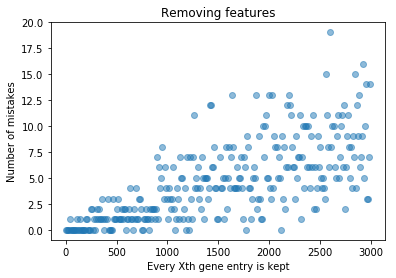

In [74]:
num_mist_list = []
X = []
for N in range(1, 3000, 10):
    clf2 = SVC(kernel = 'linear')
    clf2.fit(data.iloc[::2,::N], target[::2])
    res2 = clf2.predict(data.iloc[1::2,::N])
    cross = pd.crosstab(res2, is_hfd[1::2])
    num_mist = cross.iloc[0,1]+ cross.iloc[1,0]
    num_mist_list.append(num_mist)
    X.append(N)
plt.scatter(X, num_mist_list, alpha = 0.5)
plt.xlabel('Every Xth gene entry is kept')
plt.ylabel('Number of mistakes')
plt.title('Removing features')

You can see that the number of wrong assignments in the prediction dataset increases with the number of removed features

Text(0.5,1,'Reducing sample size')

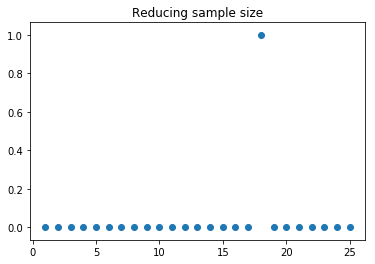

In [76]:
'''Reducing sample sice'''
num_mist_list = []
X = []
for N in range(1, 26):
    clf3 = SVC(kernel = 'linear')
    clf3.fit(data.iloc[::N,:], target[::N])
    res3 = clf3.predict(data[1::N])
    cross = pd.crosstab(res3, is_hfd[1::N])
    num_mist = cross.iloc[0,1]+ cross.iloc[1,0]
    num_mist_list.append(num_mist)
    X.append(N)
plt.scatter(X, num_mist_list)
plt.title('Reducing sample size')

The reduction of the sample size however does not result in significant amounts of mistakes

### 1.5: Perform cross-validation
Previously you had separated your data into a disjoint training and testing set, trained the model with the training set and computed its accuracy on the testing set. But you could also switch them around (train with `1::2`, test with `::2`) and compute a second accuracy value. The average of those two values would give you an even better estimate of the real accuracy. This would be called a *2-fold cross-validation*.

3-fold cross-validation is when you split your data to D1/D2/D3 thirds, train the model with D1+D2 and test on D3. Then train with D1+D3 and test on D2, finally train with D2+D3 and test on D1. The average of the three accuracy values would be your model's 3-fold cross-validated accuracy.

(Sidenote: the *model* is the SVM with whatever parameters it has (linear + defaults) and the features that you use. During cross-validation you test different *instances* of the same model: you train them with different data so they will all end up slightly different, you test them with different data so the accuracy estimates will also be different, but you are validating the same *model* all along.)

`sklearn` gives you helper classes to split your data into training and testing sets following a cross-validation scheme, saving you most of the legwork. Some classes even support features like random shuffling, or stratification (keeping labels balanced across training/testing classes). Browse the documentation, choose one that you like, and cross-validate your model on the restricted amount of features chosen in 1.4.2.

In [83]:
N = 2500
clf2 = SVC(kernel = 'linear')
clf2.fit(data.iloc[::2,::N], target[::2])
res2 = clf2.predict(data.iloc[1::2,::N])
pd.crosstab(res2, is_hfd[1::2])
#SVC.score(res2, is_hfd[1::2])
sklearn.metrics.accuracy_score(res2, is_hfd[1::2])

0.7

In [105]:
N = 2500
data_cut = data.iloc[:,::N]
kf = KFold(n_splits=2, random_state=111, shuffle=True)
kf.get_n_splits(data)
print(kf)
acc_list = []
for train_index, test_index in kf.split(data_cut):
    
    X_train, X_test = data_cut.iloc[train_index], data_cut.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf5 = SVC(kernel = 'linear')
    clf5.fit(X_train, y_train)
    res5 = clf5.predict(X_test)
    display(pd.crosstab(res5, y_test))
    print(sklearn.metrics.accuracy_score(res5, y_test))
    acc_list.append(sklearn.metrics.accuracy_score(res5, y_test))
avg_acc = sum(acc_list)/len(acc_list)
print('Average acc: ', avg_acc)

KFold(n_splits=2, random_state=111, shuffle=True)


col_0,0,1
row_0,,
0,14,13
1,4,10


0.5853658536585366


col_0,0,1
row_0,,
0,18,2
1,5,15


0.825
Average acc:  0.7051829268292682


### 1.6: Optional: Play around

Ideas: Test the limits of the linear SVM by choosing an increasing number of random features, train and cross-validate multiple SVM instances for each, and plot the average accuracy as a function the number of features used. Try different kernels and parameters. Test robustness: add noise to the data, or introduce a few random mistakes in the training labels.

# Played around a lot in sec 1.4.2 already

In [107]:

noise = np.random.normal(loc = 0, scale = 1.0, size = np.shape(data))
data_noise = noise + data

In [108]:
#N = 2500
data_cut = data_noise.copy()
#data_cut = data.iloc[:,::N]
kf = KFold(n_splits=2, random_state=111, shuffle=True)
kf.get_n_splits(data)
print(kf)
acc_list = []
for train_index, test_index in kf.split(data_cut):
    
    X_train, X_test = data_cut.iloc[train_index], data_cut.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf5 = SVC(kernel = 'linear')
    clf5.fit(X_train, y_train)
    res5 = clf5.predict(X_test)
    display(pd.crosstab(res5, y_test))
    print(sklearn.metrics.accuracy_score(res5, y_test))
    acc_list.append(sklearn.metrics.accuracy_score(res5, y_test))
avg_acc = sum(acc_list)/len(acc_list)
print('Average acc: ', avg_acc)

KFold(n_splits=2, random_state=111, shuffle=True)


col_0,0,1
row_0,,
0,18,3
1,0,20


0.926829268292683


col_0,0,1
row_0,,
0,22,0
1,1,17


0.975
Average acc:  0.9509146341463415


In [126]:
def noise_add(data, scale):
    noise = np.random.normal(loc = 0, scale = scale, size = np.shape(data))
    data_noise = noise + data
    data_cut = data_noise.copy()
    #data_cut = data.iloc[:,::N]
    kf = KFold(n_splits=2, random_state=111, shuffle=True)
    #kf.get_n_splits(data)
    print(kf)
    acc_list = []
    for train_index, test_index in kf.split(data_cut):

        X_train, X_test = data_cut.iloc[train_index], data_cut.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf5 = SVC(kernel = 'linear')
        clf5.fit(X_train, y_train)
        res5 = clf5.predict(X_test)
        #display(pd.crosstab(res5, y_test))
        #print(sklearn.metrics.accuracy_score(res5, y_test))
        acc_list.append(sklearn.metrics.accuracy_score(res5, y_test))
    avg_acc = sum(acc_list)/len(acc_list)
    #print('Average acc: ', avg_acc)
    return avg_acc

KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)


Text(0.5,1,'Robustness towards noise')

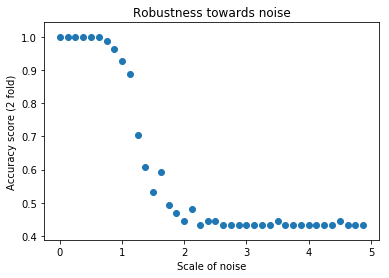

In [127]:
avg_acc_list = []
scale_list = []
for scale in np.arange(0,5, 0.125):
    scale_list.append(scale)
    avg_acc = noise_add(data, scale)
    avg_acc_list.append(avg_acc)
plt.scatter(scale_list, avg_acc_list)  
plt.xlabel('Scale of noise')
plt.ylabel('Accuracy score (2 fold)')
plt.title('Robustness towards noise')

In [138]:
def dev_noise_add(data, scale, kind = 'exp'):
    if kind == 'dob_norm':
        
        other_scale = np.abs(np.random.normal(loc = 0, scale = scale))
        noise = np.random.normal(loc = 0, scale = other_scale)
    elif kind == 'exp':
        noise = np.random.exponential(scale = scale)
    data_noise = noise + data
    data_cut = data_noise.copy()
    #data_cut = data.iloc[:,::N]
    kf = KFold(n_splits=2, random_state=111, shuffle=True)
    #kf.get_n_splits(data)
    print(kf)
    acc_list = []
    for train_index, test_index in kf.split(data_cut):

        X_train, X_test = data_cut.iloc[train_index], data_cut.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]
        clf5 = SVC(kernel = 'linear')
        clf5.fit(X_train, y_train)
        res5 = clf5.predict(X_test)
        #display(pd.crosstab(res5, y_test))
        #print(sklearn.metrics.accuracy_score(res5, y_test))
        acc_list.append(sklearn.metrics.accuracy_score(res5, y_test))
    avg_acc = sum(acc_list)/len(acc_list)
    #print('Average acc: ', avg_acc)
    return avg_acc


In [ ]:
avg_acc_list = []
scale_list = []
#for scale in np.arange(0,5, 0.125):
for scale in np.arange(0,1000, 10):
    scale_list.append(scale)
    avg_acc = dev_noise_add(data, scale, kind = 'exp')
    avg_acc_list.append(avg_acc)
plt.scatter(scale_list, avg_acc_list)  
plt.xlabel('Scale of noise')
plt.ylabel('Accuracy score (2 fold)')
plt.title('Robustness towards noise')

KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
KFold(n_splits=2, random_state=111, shuffle=True)
